In [1]:
%load_ext autoreload
%autoreload 2

In [28]:
import os, pickle, time
import pandas as pd
import numpy as np
from datetime import datetime
from utils.data.process_gene_expr import process_gene_expr
from utils.globals import FEATS_MAP

def zero_nan_ratio(tmp_df):
    zero_ratio = (tmp_df == 0).sum().sum() / tmp_df.size
    nan_ratio = tmp_df.isnull().sum().sum() / tmp_df.size
    return zero_ratio * 100, nan_ratio * 100

In [28]:
with open("data/processed_data/unique_feats_union.p", "rb") as file:  # Replace "file_name.p" with your file"s path
    uniq_feats = pickle.load(file)
print("biological_sex:", uniq_feats["biological_sex"])
print("infancy_vac:", uniq_feats["infancy_vac"])
print("ethnicity:", uniq_feats["ethnicity"])
print("race:", uniq_feats["race"])
uniq_feats.keys()

biological_sex: ['female', 'male']
infancy_vac: ['wp', 'ap']
ethnicity: ['unknown', 'hispanic or latino', 'not hispanic or latino']
race: ['more than one race', 'american indian/alaska native', 'native hawaiian or other pacific islander', 'unknown or not reported', 'black or african american', 'white', 'asian']


dict_keys(['isotype_antigen', 'cell_type_name', 'protein_id_olink', 'protein_id_legendplex', 'stimulation_tcell_activ', 'stimulation_tcell_polar', 'stimulation_protein', 'versioned_ensembl_gene_id', 'infancy_vac', 'biological_sex', 'ethnicity', 'race'])

# merged_metadata

In [39]:
years = [2023,2022,2021,2020]

def calculate_age(birthdate):
    birthdate = datetime.strptime(birthdate, "%Y-%m-%d")
    today = datetime.today()
    age = today.year - birthdate.year + (today.month - birthdate.month) / 12 + \
            (today.day - birthdate.day) / 365.25
    return age


for yr in years:
    dt_1 = "training_dataset"
    dt_2 = "LD"
    if yr == 2023:
        dt_1 = "challenge_dataset"
        dt_2 = "BD"
    specimen_dpth = f"data/3rd_challenge/raw_datasets/{dt_1}/{yr}{dt_2}_specimen.tsv"
    subject_dpth = f"data/3rd_challenge/raw_datasets/{dt_1}/{yr}{dt_2}_subject.tsv"
    specimen_meta = pd.read_csv(specimen_dpth, sep="\t")
    subject_meta = pd.read_csv(subject_dpth, sep="\t")
    merged_meta = pd.merge(specimen_meta, subject_meta, on="subject_id")

    merged_meta["day_diff_14"] = merged_meta["actual_day_relative_to_boost"].apply(lambda x: 14 - x)
    merged_meta["day_diff_1"] = merged_meta["actual_day_relative_to_boost"].apply(lambda x: 1 - x)
    merged_meta["day_diff_3"] = merged_meta["actual_day_relative_to_boost"].apply(lambda x: 3 - x)
    merged_meta["day_diff_30"] = merged_meta["actual_day_relative_to_boost"].apply(lambda x: 30 - x)


    merged_meta["year_of_birth"] = pd.to_datetime(merged_meta["year_of_birth"])
    merged_meta["date_of_boost"] = pd.to_datetime(merged_meta["date_of_boost"])
    merged_meta["adjusted_boost_date"] = merged_meta["date_of_boost"] + pd.to_timedelta(merged_meta["actual_day_relative_to_boost"], unit="D")
    merged_meta["age"] = (merged_meta["adjusted_boost_date"] - merged_meta["year_of_birth"]).dt.total_seconds() / (365.25 * 24 * 60 * 60)
    merged_meta.drop(columns=["adjusted_boost_date"], inplace=True)
    
    merged_meta["biological_sex"] = merged_meta["biological_sex"].str.lower()
    merged_meta["biological_sex"] = merged_meta["biological_sex"].map(FEATS_MAP["biological_sex"])
    
    merged_meta["infancy_vac"] = merged_meta["infancy_vac"].str.lower()
    merged_meta["infancy_vac"] = merged_meta["infancy_vac"].map(FEATS_MAP["infancy_vac"])
    
    merged_meta["ethnicity"] = merged_meta["ethnicity"].str.lower()
    merged_meta["ethnicity"] = merged_meta["ethnicity"].map(FEATS_MAP["ethnicity"])
    
    merged_meta["race"] = merged_meta["race"].str.lower()
    merged_meta["race"] = merged_meta["race"].map(FEATS_MAP["race"])

    days = [1, 3, 14, 30]
    all_days = []
    for day in days:
        day_df = (merged_meta[merged_meta['actual_day_relative_to_boost'] == day]
                            .sort_values('specimen_id', ascending=False)
                            .drop_duplicates(subset='subject_id')
                            [['subject_id', 'specimen_id']]
                            .rename(columns={'specimen_id': f'd{day}_specimen_id'}))
        all_days.append(day_df)

    for day, day_df in zip(days, all_days):
        # Merge back into the original DataFrame
        merged_meta = merged_meta.merge(day_df, on='subject_id', how='left')
        merged_meta[f'd{day}_specimen_id'] = merged_meta[f'd{day}_specimen_id'].astype('Int64')
        merged_meta[f'd{day}_specimen_id'] = merged_meta[f'd{day}_specimen_id'].fillna(-1)
        
    merged_meta.to_parquet(f"data/processed_data/{yr}_metadata.parquet", engine='pyarrow')
    
# merged_meta["year_of_birth"][:4]
merged_meta.head()

,specimen_id,subject_id,actual_day_relative_to_boost,planned_day_relative_to_boost,specimen_type,visit,infancy_vac,biological_sex,ethnicity,race,...,dataset,day_diff_14,day_diff_1,day_diff_3,day_diff_30,age,d1_specimen_id,d3_specimen_id,d14_specimen_id,d30_specimen_id
0,1,1,-3,0,Blood,1,1,0,2,4,...,2020_dataset,17,4,6,33,30.688569,2,3,-1,-1
1,2,1,1,1,Blood,2,1,0,2,4,...,2020_dataset,13,0,2,29,30.699521,2,3,-1,-1
2,3,1,3,3,Blood,3,1,0,2,4,...,2020_dataset,11,-2,0,27,30.704997,2,3,-1,-1
3,4,1,7,7,Blood,4,1,0,2,4,...,2020_dataset,7,-6,-4,23,30.715948,2,3,-1,-1
4,5,1,11,14,Blood,5,1,0,2,4,...,2020_dataset,3,-10,-8,19,30.726899,2,3,-1,-1


In [40]:
years = [2020, 2021, 2022, 2023]
rt_path = "data/processed_data"
concat = []
for yr in years:
    df_path = os.path.join(rt_path, f"{yr}_metadata.parquet")
    df = pd.read_parquet(df_path)
    concat.append(df)
    
all_metadata = pd.concat(concat, ignore_index=True)
all_metadata.to_parquet(f"data/processed_data/all_metadata.parquet", engine='pyarrow')
print("all_metadata shape", all_metadata.shape)
print("num of unique specimen_id", len(all_metadata["specimen_id"].unique()))
all_metadata.head()

all_metadata shape (1103, 22)
num of unique specimen_id 1103


,specimen_id,subject_id,actual_day_relative_to_boost,planned_day_relative_to_boost,specimen_type,visit,infancy_vac,biological_sex,ethnicity,race,...,dataset,day_diff_14,day_diff_1,day_diff_3,day_diff_30,age,d1_specimen_id,d3_specimen_id,d14_specimen_id,d30_specimen_id
0,1,1,-3,0,Blood,1,1,0,2,4,...,2020_dataset,17,4,6,33,30.688569,2,3,-1,-1
1,2,1,1,1,Blood,2,1,0,2,4,...,2020_dataset,13,0,2,29,30.699521,2,3,-1,-1
2,3,1,3,3,Blood,3,1,0,2,4,...,2020_dataset,11,-2,0,27,30.704997,2,3,-1,-1
3,4,1,7,7,Blood,4,1,0,2,4,...,2020_dataset,7,-6,-4,23,30.715948,2,3,-1,-1
4,5,1,11,14,Blood,5,1,0,2,4,...,2020_dataset,3,-10,-8,19,30.726899,2,3,-1,-1


In [101]:
all_metadata[all_metadata["dataset"] == "2023_dataset"]["specimen_id"][:5]

939    940
940    942
941    943
942    950
943    954
Name: specimen_id, dtype: int64

# store specimen_id as index for challenge 2023, training 2022,2021,2020

In [35]:
all_metadata = pd.read_parquet("data/processed_data/all_metadata.parquet")
print(all_metadata.shape)
all_metadata.head()

(1103, 22)


,specimen_id,subject_id,actual_day_relative_to_boost,planned_day_relative_to_boost,specimen_type,visit,infancy_vac,biological_sex,ethnicity,race,...,dataset,day_diff_14,day_diff_1,day_diff_3,day_diff_30,age,d1_specimen_id,d3_specimen_id,d14_specimen_id,d30_specimen_id
0,1,1,-3,0,Blood,1,1,0,2,4,...,2020_dataset,17,4,6,33,38.852498,2,3,-1,-1
1,2,1,1,1,Blood,2,1,0,2,4,...,2020_dataset,13,0,2,29,38.852498,2,3,-1,-1
2,3,1,3,3,Blood,3,1,0,2,4,...,2020_dataset,11,-2,0,27,38.852498,2,3,-1,-1
3,4,1,7,7,Blood,4,1,0,2,4,...,2020_dataset,7,-6,-4,23,38.852498,2,3,-1,-1
4,5,1,11,14,Blood,5,1,0,2,4,...,2020_dataset,3,-10,-8,19,38.852498,2,3,-1,-1


In [41]:
# save challenge input index
challenge_idx = all_metadata[all_metadata["dataset"] == "2023_dataset"]["specimen_id"].to_numpy()

print("all challenge idx", len(challenge_idx))
np.savez("data/processed_data/challenge_cell_idx.npz", cell_idx=challenge_idx)


all challenge idx 164


In [147]:
# save training data input index
dataset = ["2022_dataset", "2021_dataset", "2020_dataset"]
tmp_df = all_metadata[
    (all_metadata["dataset"].isin(dataset)) &
    (all_metadata["specimen_id"] != all_metadata["d1_specimen_id"]) &
    (all_metadata["specimen_id"] != all_metadata["d3_specimen_id"]) &
    (all_metadata["specimen_id"] != all_metadata["d14_specimen_id"]) & 
    (all_metadata["specimen_id"] != all_metadata["d30_specimen_id"])
]
train_input_idx = tmp_df["specimen_id"].to_numpy()
print(len(train_input_idx))
np.savez("data/processed_data/train_1_input_cell_idx.npz", cell_idx=train_input_idx)

571


In [148]:
# save train target index
dataset = ["2022_dataset", "2021_dataset", "2020_dataset"]
tmp_df = all_metadata[
    (all_metadata["dataset"].isin(dataset)) &
    ((all_metadata["specimen_id"] == all_metadata["d1_specimen_id"]) |
    (all_metadata["specimen_id"] == all_metadata["d3_specimen_id"]) |
    (all_metadata["specimen_id"] == all_metadata["d14_specimen_id"]) | 
    (all_metadata["specimen_id"] == all_metadata["d30_specimen_id"]))
]
train_target_idx = tmp_df["specimen_id"].to_numpy()
print(len(train_target_idx))
np.savez("data/processed_data/train_target_cell_idx.npz", cell_idx=train_target_idx)

368


In [151]:
tmp = np.load("data/processed_data/train_1_target_cell_idx.npz")["cell_idx"]
a = all_metadata.set_index("specimen_id")
a.loc[tmp, :].head()

,subject_id,actual_day_relative_to_boost,planned_day_relative_to_boost,specimen_type,visit,infancy_vac,biological_sex,ethnicity,race,year_of_birth,...,dataset,day_diff_14,day_diff_1,day_diff_3,day_diff_30,age,d1_specimen_id,d3_specimen_id,d14_specimen_id,d30_specimen_id
specimen_id,,,,,,,,,,,,,,,,,,,,,
2,1,1,1,Blood,2,1,0,2,4,1986-01-01,...,2020_dataset,13,0,2,29,38.852498,2,3,-1,-1
3,1,3,3,Blood,3,1,0,2,4,1986-01-01,...,2020_dataset,11,-2,0,27,38.852498,2,3,-1,-1
12,2,1,1,Blood,2,1,0,2,4,1968-01-01,...,2020_dataset,13,0,2,29,56.852498,12,13,15,-1
13,2,3,3,Blood,3,1,0,2,4,1968-01-01,...,2020_dataset,11,-2,0,27,56.852498,12,13,15,-1
15,2,14,14,Blood,5,1,0,2,4,1968-01-01,...,2020_dataset,0,-13,-11,16,56.852498,12,13,15,-1


##### just 2021,2022 idx

In [7]:
all_metadata = pd.read_parquet("data/processed_data/all_metadata.parquet")
# save training data input index
dataset = ["2021_dataset", "2022_dataset"]
tmp_df = all_metadata[
    (all_metadata["dataset"].isin(dataset)) &
    (all_metadata["specimen_id"] != all_metadata["d1_specimen_id"]) &
    (all_metadata["specimen_id"] != all_metadata["d3_specimen_id"]) &
    (all_metadata["specimen_id"] != all_metadata["d14_specimen_id"]) & 
    (all_metadata["specimen_id"] != all_metadata["d30_specimen_id"])
]
train_input_idx = tmp_df["specimen_id"].to_numpy()
print(len(train_input_idx))
np.savez("data/processed_data/train_2_input_cell_idx.npz", cell_idx=train_input_idx)

tmp_df = all_metadata[
    (all_metadata["dataset"].isin(dataset)) &
    ((all_metadata["specimen_id"] == all_metadata["d1_specimen_id"]) |
    (all_metadata["specimen_id"] == all_metadata["d3_specimen_id"]) |
    (all_metadata["specimen_id"] == all_metadata["d14_specimen_id"]) | 
    (all_metadata["specimen_id"] == all_metadata["d30_specimen_id"]))
]
train_target_idx = tmp_df["specimen_id"].to_numpy()
print(len(train_target_idx))
np.savez("data/processed_data/train_2_target_cell_idx.npz", cell_idx=train_target_idx)


287
185


# check zero ratio and missing value ratio

In [11]:
raw_path = "data/3rd_challenge/raw_datasets"
datasets = ["training_dataset", "challenge_dataset"]
for ds in datasets:
    rt_path = os.path.join(raw_path, ds)
    for file_name in os.listdir(rt_path):
        file_path = os.path.join(rt_path, file_name)
        tmp_start_t = time.time()
        tmp_df = pd.read_csv(file_path, sep='\t')
        t_read_data = time.time() - tmp_start_t
        zero_ratio = (tmp_df == 0).sum().sum() / tmp_df.size
        nan_ratio = tmp_df.isnull().sum().sum() / tmp_df.size

        if zero_ratio == 0 and nan_ratio == 0:
            continue

        print(f"{file_name} ----------------")
        print("Reading data takes       :", f"{t_read_data:4f} secs")
        print("Proportion of zero values:", zero_ratio * 100, "%")
        print("Proportion of NaN values :", nan_ratio * 100, "%")
        print()


2020LD_plasma_ab_titer.tsv ----------------
Reading data takes       : 0.043226 secs
Proportion of zero values: 0.3212246192893401 %
Proportion of NaN values : 0.0003965736040609137 %

2022LD_pbmc_cell_frequency.tsv ----------------
Reading data takes       : 0.003356 secs
Proportion of zero values: 0.08501118568232661 %
Proportion of NaN values : 0.0 %

2020LD_pbmc_gene_expression.tsv ----------------
Reading data takes       : 3.094383 secs
Proportion of zero values: 26.8939697132555 %
Proportion of NaN values : 0.0 %

2020LD_plasma_cytokine_concentration_by_olink.tsv ----------------
Reading data takes       : 0.078921 secs
Proportion of zero values: 0.0 %
Proportion of NaN values : 14.396765043152875 %

2020LD_specimen.tsv ----------------
Reading data takes       : 0.000667 secs
Proportion of zero values: 2.4982155603140614 %
Proportion of NaN values : 0.0 %

2022LD_plasma_ab_titer.tsv ----------------
Reading data takes       : 0.003449 secs
Proportion of zero values: 4.415491028

In [36]:
years = [2022, 2021, 2020]
days = [1, 3, 14, 30]
proc_path = "data/processed_data"
for yr in years:
    metadata = os.path.join(proc_path, f"{yr}_metadata.parquet")
    metadata = pd.read_parquet(metadata)
    for day in days:
        missing_rate = metadata[f"d{day}_specimen_id"].isnull().mean() * 100
        if missing_rate != 0:
            print(f"{yr} has missing value on day {day}:  {missing_rate:4f}")
    print()
    

2022 has missing value on day 3:  4.761905
2022 has missing value on day 14:  14.761905
2022 has missing value on day 30:  76.666667

2021 has missing value on day 14:  2.671756
2021 has missing value on day 30:  60.687023

2020 has missing value on day 1:  4.770017
2020 has missing value on day 3:  10.732538
2020 has missing value on day 14:  11.754685
2020 has missing value on day 30:  71.379898



# gene expr

##### 2020,2021,2022,2023

In [140]:
num = 1

input_idx = np.load(f"data/processed_data/train_{num}_input_cell_idx.npz")["cell_idx"]
target_idx = np.load(f"data/processed_data/train_{num}_target_cell_idx.npz")["cell_idx"]

gene_expr_2020 = pd.read_csv("data/3rd_challenge/raw_datasets/training_dataset/2020LD_pbmc_gene_expression.tsv", sep='\t')
gene_expr_2021 = pd.read_csv("data/3rd_challenge/raw_datasets/training_dataset/2021LD_pbmc_gene_expression.tsv", sep='\t')
gene_expr_2022 = pd.read_csv("data/3rd_challenge/raw_datasets/training_dataset/2022LD_pbmc_gene_expression.tsv", sep='\t')
gene_expr_2023 = pd.read_csv("data/3rd_challenge/raw_datasets/challenge_dataset/2023BD_pbmc_gene_expression.tsv", sep='\t')
all_df = [gene_expr_2020, gene_expr_2021, gene_expr_2022, gene_expr_2023]
gene_expr_merged = pd.concat(all_df, axis=0, ignore_index=True)
print("gene expr 2020:", gene_expr_2020.shape)
print("gene expr 2021:", gene_expr_2021.shape)
print("gene expr 2022:", gene_expr_2022.shape)
print("gene expr 2023:", gene_expr_2023.shape)
print("merged gene expr:", gene_expr_merged.shape)
gene_expr_merged.head()


gene expr 2020: (10494360, 4)
gene expr 2021: (10494360, 4)
gene expr 2022: (8570394, 4)
gene expr 2023: (9270018, 4)
merged gene expr: (38829132, 4)


,versioned_ensembl_gene_id,specimen_id,raw_count,tpm
0,ENSG00000000003.14,70,24,0.949
1,ENSG00000000005.5,70,0,0.000
2,ENSG00000000419.12,70,840,124.738
3,ENSG00000000457.13,70,329,8.567
4,ENSG00000000460.16,70,179,5.377


In [141]:
gene_expr_merged = gene_expr_merged.drop(columns=["raw_count"])
gene_expr_merged = gene_expr_merged.pivot(index="specimen_id",
                                          columns="versioned_ensembl_gene_id",
                                          values="tpm")
gene_expr_merged = gene_expr_merged.reset_index().set_index('specimen_id')
# gene_expr_merged.iloc[4,:3]

In [142]:
missing_ids = list(set(input_idx) - set(gene_expr_merged.index))

missing_df = pd.DataFrame(0, index=missing_ids, columns=gene_expr_merged.columns[0:])
missing_df.index.name = "specimen_id"

gene_expr_merged = pd.concat([gene_expr_merged, missing_df], ignore_index=False)
gene_expr_merged.shape

(992, 58302)

In [145]:
258 in gene_expr_merged.index

True

In [73]:
print("pivot gene expr merged:", gene_expr_merged.shape)
zero_ratio, nan_ratio = zero_nan_ratio(gene_expr_merged)
print("zero ratio:", zero_ratio)
print("nan ratio:", nan_ratio)
gene_expr_merged.head()

pivot gene expr merged: (992, 58302)
zero ratio: 71.99885800409658
nan ratio: 0.0


versioned_ensembl_gene_id,ENSG00000000003.14,ENSG00000000005.5,ENSG00000000419.12,ENSG00000000457.13,ENSG00000000460.16,ENSG00000000938.12,ENSG00000000971.15,ENSG00000001036.13,ENSG00000001084.10,ENSG00000001167.14,...,ENSG00000284739.1,ENSG00000284740.1,ENSG00000284741.1,ENSG00000284742.1,ENSG00000284743.1,ENSG00000284744.1,ENSG00000284745.1,ENSG00000284746.1,ENSG00000284747.1,ENSG00000284748.1
specimen_id,,,,,,,,,,,,,,,,,,,,,
1,1.198,0.0,155.355,9.383,5.159,350.208,5.064,18.297,13.907,78.239,...,0.0,1.219,0.0,0.0,0.0,0.0,0.0,0.0,1.173,0.0
2,0.596,0.0,118.828,8.010,4.680,587.745,2.655,22.644,12.114,70.730,...,0.0,0.273,0.0,0.0,0.0,0.0,0.0,0.0,0.657,0.0
3,1.077,0.0,120.340,8.245,4.314,424.164,3.437,20.721,14.299,70.754,...,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.913,0.0
4,1.066,0.0,137.335,10.172,5.671,308.691,4.174,18.090,14.833,60.723,...,0.0,0.473,0.0,0.0,0.0,0.0,0.0,0.0,0.947,0.0
5,0.987,0.0,135.165,9.341,4.892,391.157,4.134,20.390,13.479,73.071,...,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.783,0.0


In [74]:
gene_expr_merged.to_parquet('data/processed_data/data_1_gene_expr_merged.parquet', index=True)

In [76]:
transformed_data = process_gene_expr(filename="data_1_processed_gene_expr_merged.parquet",
                                     df=gene_expr_merged)
transformed_data.shape

dataframe shape: (992, 58302)


/local/disk1/chrenx/conda-env/envs/cmi/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


processed data is saved to data/processed_data/data_1_processed_gene_expr_merged.parquet


(992, 256)

##### 2021,2022,2023

In [79]:
num = 2

input_idx = np.load(f"data/processed_data/train_{num}_input_cell_idx.npz")["cell_idx"]
target_idx = np.load(f"data/processed_data/train_{num}_target_cell_idx.npz")["cell_idx"]

gene_expr_2021 = pd.read_csv("data/3rd_challenge/raw_datasets/training_dataset/2021LD_pbmc_gene_expression.tsv", sep='\t')
gene_expr_2022 = pd.read_csv("data/3rd_challenge/raw_datasets/training_dataset/2022LD_pbmc_gene_expression.tsv", sep='\t')
gene_expr_2023 = pd.read_csv("data/3rd_challenge/raw_datasets/challenge_dataset/2023BD_pbmc_gene_expression.tsv", sep='\t')
all_df = [gene_expr_2021, gene_expr_2022, gene_expr_2023]
gene_expr_merged = pd.concat(all_df, axis=0, ignore_index=True)
gene_expr_merged = gene_expr_merged.drop(columns=["raw_count"])
gene_expr_merged = gene_expr_merged.pivot(index="specimen_id",
                                          columns="versioned_ensembl_gene_id",
                                          values="tpm")
gene_expr_merged = gene_expr_merged.reset_index().set_index('specimen_id')

missing_ids = list(set(input_idx) - set(gene_expr_merged.index))
missing_df = pd.DataFrame(0, index=missing_ids, columns=gene_expr_merged.columns[0:])
missing_df.index.name = "specimen_id"
gene_expr_merged = pd.concat([gene_expr_merged, missing_df], ignore_index=False)

gene_expr_merged.to_parquet('data/processed_data/data_2_gene_expr_merged.parquet', index=True)
transformed_data = process_gene_expr(filename="data_2_processed_gene_expr_merged.parquet",
                                     df=gene_expr_merged)
transformed_data.shape

dataframe shape: (612, 58302)


/local/disk1/chrenx/conda-env/envs/cmi/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


processed data is saved to data/processed_data/data_2_processed_gene_expr_merged.parquet


(612, 256)

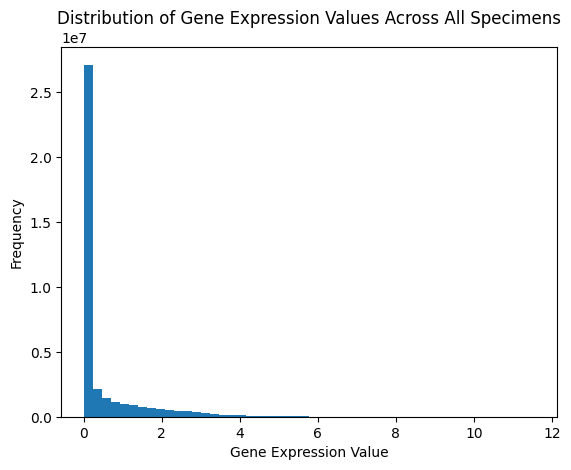

In [33]:
import matplotlib.pyplot as plt

# Assuming `data` is your dataset with shape (num_specimens, num_genes)
# Flatten the data to create a single array of gene expression values
tmp = transformed_data.flatten() # If it's a DataFrame, use `.values`
bins = 50 # np.arange(10, 30, 1)
plt.hist(tmp, bins=bins)  # Adjust bins as needed
plt.xlabel("Gene Expression Value")
plt.ylabel("Frequency")
plt.title("Distribution of Gene Expression Values Across All Specimens")
plt.show()

# cell_frequency

##### 2020,2021,2022,2023

In [155]:
num = 1

input_idx = np.load(f"data/processed_data/train_{num}_input_cell_idx.npz")["cell_idx"]
target_idx = np.load(f"data/processed_data/train_{num}_target_cell_idx.npz")["cell_idx"]


cell_freq_2020 = pd.read_csv("data/3rd_challenge/raw_datasets/training_dataset/2020LD_pbmc_cell_frequency.tsv", sep='\t')
cell_freq_2021 = pd.read_csv("data/3rd_challenge/raw_datasets/training_dataset/2021LD_pbmc_cell_frequency.tsv", sep='\t')
cell_freq_2022 = pd.read_csv("data/3rd_challenge/raw_datasets/training_dataset/2022LD_pbmc_cell_frequency.tsv", sep='\t')
cell_freq_2023 = pd.read_csv("data/3rd_challenge/raw_datasets/challenge_dataset/2023BD_pbmc_cell_frequency.tsv", sep='\t')
all_df = [cell_freq_2020, cell_freq_2021, cell_freq_2022, cell_freq_2023]
cell_freq_merged = pd.concat(all_df, axis=0, ignore_index=True)
print("cell_freq 2020:", cell_freq_2020.shape)
print("cell_freq 2021:", cell_freq_2021.shape)
print("cell_freq 2022:", cell_freq_2022.shape)
print("cell_freq 2023:", cell_freq_2023.shape)
print("merged cell_freq:", cell_freq_merged.shape)
cell_freq_merged.head()


cell_freq 2020: (2483, 3)
cell_freq 2021: (8250, 3)
cell_freq 2022: (7450, 3)
cell_freq 2023: (6864, 3)
merged cell_freq: (25047, 3)


,specimen_id,cell_type_name,percent_live_cell
0,223,Monocytes,16.094765
1,223,CD33HLADR,17.203468
2,223,Classical_Monocytes,15.129653
3,223,Non-Classical_Monocytes,0.488212
4,223,Intermediate_Monocytes,0.000000


In [156]:
cell_freq_merged = cell_freq_merged.pivot(index="specimen_id",
                                          columns="cell_type_name",
                                          values="percent_live_cell")
cell_freq_merged = cell_freq_merged.reset_index().set_index('specimen_id')
print("pivot cell_freq_merged:", cell_freq_merged.shape)
zero_ratio, nan_ratio = zero_nan_ratio(cell_freq_merged)
print("zero ratio:", zero_ratio)
print("nan ratio:", nan_ratio)
cell_freq_merged.head()

pivot cell_freq_merged: (557, 66)
zero ratio: 0.17137261302431858
nan ratio: 32.014036233066754


cell_type_name,ASCs (Plasmablasts),Activated B cells (ABCs),Activated granulocytes,Antibody secreting B cells (ASCs),B cells (CD19+CD20+CD3-CD14-CD56-),B cells (CD19+CD3-CD14-CD56-),B:NK doublets (CD19+CD3-CD14-CD56+),BNK doublets,Basophils,Bcells,...,TemCD4,TemCD8,TemraCD4,TemraCD8,Tregs,cDC1,cDC2,mDC,non-pDCs,pDC
specimen_id,,,,,,,,,,,,,,,,,,,,,
27,0.61,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.651779,7.237643,...,3.317633,0.801122,0.284570,0.277285,0.382918,NaN,NaN,0.355827,NaN,0.098803
28,0.19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.239507,9.663399,...,5.171692,0.363927,1.150744,0.201935,0.257729,NaN,NaN,0.422257,NaN,0.294502
29,0.42,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.250735,13.209529,...,4.480683,3.486655,1.980693,4.325669,0.000000,NaN,NaN,0.000000,NaN,0.000000
30,1.77,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.944128,10.265415,...,6.705377,1.154986,1.025875,0.650820,0.250504,NaN,NaN,0.486975,NaN,0.137883
31,1.49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.008901,12.993769,...,3.344288,0.740797,0.224590,0.248277,0.219326,NaN,NaN,0.633765,NaN,0.164407


In [157]:
missing_ids = list(set(input_idx) - set(cell_freq_merged.index))
missing_df = pd.DataFrame(0, index=missing_ids, columns=cell_freq_merged.columns[0:])
missing_df.index.name = "specimen_id"
cell_freq_merged = pd.concat([cell_freq_merged, missing_df], ignore_index=False)
cell_freq_merged.shape

(918, 66)

In [158]:
cell_freq_merged.to_parquet('data/processed_data/data_1_cell_freq_merged.parquet', index=True)

In [159]:
from utils.data.process_cell_freq import process_cell_freq

processed_data = process_cell_freq(filename="data_1_processed_cell_freq_merged.parquet",
                                     df=cell_freq_merged)
processed_data.shape

dataframe shape: (918, 66)
ignore nan
processed data is saved to data/processed_data/data_1_processed_cell_freq_merged.parquet


/local/disk1/chrenx/conda-env/envs/cmi/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


(918, 66)

##### 2021,2022,2023

In [90]:
num = 2

input_idx = np.load(f"data/processed_data/train_{num}_input_cell_idx.npz")["cell_idx"]
target_idx = np.load(f"data/processed_data/train_{num}_target_cell_idx.npz")["cell_idx"]


cell_freq_2021 = pd.read_csv("data/3rd_challenge/raw_datasets/training_dataset/2021LD_pbmc_cell_frequency.tsv", sep='\t')
cell_freq_2022 = pd.read_csv("data/3rd_challenge/raw_datasets/training_dataset/2022LD_pbmc_cell_frequency.tsv", sep='\t')
cell_freq_2023 = pd.read_csv("data/3rd_challenge/raw_datasets/challenge_dataset/2023BD_pbmc_cell_frequency.tsv", sep='\t')
all_df = [cell_freq_2021, cell_freq_2022, cell_freq_2023]
cell_freq_merged = pd.concat(all_df, axis=0, ignore_index=True)
cell_freq_merged = cell_freq_merged.pivot(index="specimen_id",
                                          columns="cell_type_name",
                                          values="percent_live_cell")
cell_freq_merged = cell_freq_merged.reset_index().set_index('specimen_id')

missing_ids = list(set(input_idx) - set(cell_freq_merged.index))
missing_df = pd.DataFrame(0, index=missing_ids, columns=cell_freq_merged.columns[0:])
missing_df.index.name = "specimen_id"
cell_freq_merged = pd.concat([cell_freq_merged, missing_df], ignore_index=False)

cell_freq_merged.to_parquet('data/processed_data/data_2_cell_freq_merged.parquet', index=True)
transformed_data = process_cell_freq(filename="data_2_processed_cell_freq_merged.parquet",
                                     df=cell_freq_merged)
transformed_data.shape

dataframe shape: (579, 63)
ignore nan
processed data is saved to data/processed_data/data_2_processed_cell_freq_merged.parquet


/local/disk1/chrenx/conda-env/envs/cmi/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


(579, 63)

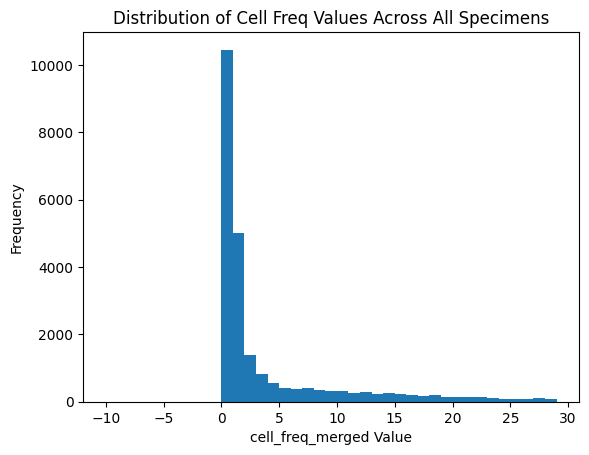

In [66]:
import matplotlib.pyplot as plt

# Assuming `data` is your dataset with shape (num_specimens, num_genes)
# Flatten the data to create a single array of gene expression values
tmp = cell_freq_merged.values.flatten() # If it's a DataFrame, use `.values`
bins = np.arange(-10, 30, 1)
plt.hist(tmp, bins=bins)  # Adjust bins as needed
plt.xlabel("cell_freq_merged Value")
plt.ylabel("Frequency")
plt.title("Distribution of Cell Freq Values Across All Specimens")
plt.show()

# ab_titer

##### 2020,2021,2022,2023

In [97]:
df_2020 = pd.read_csv("data/3rd_challenge/raw_datasets/training_dataset/2020LD_plasma_ab_titer.tsv", sep='\t')
df_2021 = pd.read_csv("data/3rd_challenge/raw_datasets/training_dataset/2021LD_plasma_ab_titer.tsv", sep='\t')
df_2022 = pd.read_csv("data/3rd_challenge/raw_datasets/training_dataset/2022LD_plasma_ab_titer.tsv", sep='\t')
df_2023 = pd.read_csv("data/3rd_challenge/raw_datasets/challenge_dataset/2023BD_plasma_ab_titer.tsv", sep='\t')
all_df = [df_2020, df_2021, df_2022, df_2023]
df_merged = pd.concat(all_df, axis=0, ignore_index=True)

df_merged = df_merged[df_merged['is_antigen_specific'] != False]
# df_merged = df_merged[df_merged['antigen'] != "Total"]

print("df 2020:", df_2020.shape)
print("df 2021:", df_2021.shape)
print("df 2022:", df_2022.shape)
print("df 2023:", df_2023.shape)
print("merged df:", df_merged.shape)

df_merged["isotype_antigen"] = df_merged["isotype"] + "_" + df_merged["antigen"]

df_merged.head()

df 2020: (31520, 8)
df 2021: (8085, 8)
df 2022: (7301, 8)
df 2023: (5670, 8)
merged df: (43703, 8)


,specimen_id,isotype,is_antigen_specific,antigen,MFI,MFI_normalised,unit,lower_limit_of_detection,isotype_antigen
2,1,IgG,True,PT,68.566139,3.736992,IU/ML,0.530000,IgG_PT
3,1,IgG,True,PRN,332.127178,2.602350,IU/ML,6.205949,IgG_PRN
4,1,IgG,True,FHA,1887.122630,34.050956,IU/ML,4.679535,IgG_FHA
5,1,IgE,True,ACT,0.100000,1.000000,IU/ML,2.816431,IgE_ACT
6,1,IgE,True,LOS,28.350649,12.872727,IU/ML,1.658149,IgE_LOS


In [98]:
df_1 = df_merged[["specimen_id", "MFI_normalised", "isotype_antigen"]]
df_1 = df_1.pivot(index="specimen_id",
                        columns="isotype_antigen",
                        values="MFI_normalised")
df_1 = df_1.reset_index().set_index('specimen_id')
print("pivot ab titer:", df_1.shape)
zero_ratio, nan_ratio = zero_nan_ratio(df_1)
print("zero ratio:", zero_ratio)
print("nan ratio:", nan_ratio)
df_1.head()

pivot ab titer: (765, 82)
zero ratio: 0.058982942770604174
nan ratio: 30.331579786386097


isotype_antigen,IgE_ACT,IgE_BETV1,IgE_DT,IgE_FELD1,IgE_FHA,IgE_FIM2/3,IgE_LOLP1,IgE_LOS,IgE_Measles,IgE_OVA,...,IgG4_PT,IgG4_PTM,IgG4_TT,IgG_DT,IgG_FHA,IgG_FIM2/3,IgG_OVA,IgG_PRN,IgG_PT,IgG_TT
specimen_id,,,,,,,,,,,,,,,,,,,,,
1,1.0,2.043895,1.0,16.469330,1.0,1.0,1.266941,12.872727,1.0,1.0,...,1.061706,1.000000,3.290050,NaN,34.050956,NaN,NaN,2.602350,3.736992,NaN
2,1.0,1.605918,1.0,18.291159,1.0,1.0,1.055784,13.636364,1.0,1.0,...,1.000000,1.000000,2.633237,NaN,4.438960,NaN,NaN,1.370393,2.255534,NaN
3,1.0,1.605918,1.0,16.760823,1.0,1.0,1.000000,13.963636,1.0,1.0,...,1.415608,1.000000,2.488474,NaN,10.337562,NaN,NaN,2.235138,3.250369,NaN
4,1.0,1.824906,1.0,23.027913,1.0,1.0,1.266941,15.709091,1.0,1.0,...,2.689656,1.655391,3.331924,NaN,0.084437,NaN,NaN,7.659956,10.874112,NaN
5,1.0,1.313933,1.0,19.748622,1.0,1.0,1.000000,13.418182,1.0,1.0,...,2.123412,1.481139,3.248177,NaN,0.084437,NaN,NaN,8.147366,12.513860,NaN


In [99]:
num = 1

input_idx = np.load(f"data/processed_data/train_{num}_input_cell_idx.npz")["cell_idx"]
target_idx = np.load(f"data/processed_data/train_{num}_target_cell_idx.npz")["cell_idx"]

missing_ids = list(set(input_idx) - set(df_1.index))
missing_df = pd.DataFrame(0, index=missing_ids, columns=df_1.columns[0:])
missing_df.index.name = "specimen_id"
df_1 = pd.concat([df_1, missing_df], ignore_index=False)
df_1.shape

(973, 82)

In [100]:
df_1.to_parquet('data/processed_data/data_1_ab_titer_merged.parquet', index=True)

In [101]:
from utils.data.process_ab_titer import process_ab_titer

processed_data = process_ab_titer(filename="data_1_processed_ab_titer_merged.parquet",
                                    df=df_1)
processed_data.shape

dataframe shape: (973, 82)
ignore nan
processed data is saved to data/processed_data/data_1_processed_ab_titer_merged.parquet


/local/disk1/chrenx/conda-env/envs/cmi/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


(973, 82)

##### 2021,2022,2023

In [102]:
df_2021 = pd.read_csv("data/3rd_challenge/raw_datasets/training_dataset/2021LD_plasma_ab_titer.tsv", sep='\t')
df_2022 = pd.read_csv("data/3rd_challenge/raw_datasets/training_dataset/2022LD_plasma_ab_titer.tsv", sep='\t')
df_2023 = pd.read_csv("data/3rd_challenge/raw_datasets/challenge_dataset/2023BD_plasma_ab_titer.tsv", sep='\t')
all_df = [df_2021, df_2022, df_2023]
df_merged = pd.concat(all_df, axis=0, ignore_index=True)

df_merged = df_merged[df_merged['is_antigen_specific'] != False]
df_merged["isotype_antigen"] = df_merged["isotype"] + "_" + df_merged["antigen"]


df_1 = df_merged[["specimen_id", "MFI_normalised", "isotype_antigen"]]
df_1 = df_1.pivot(index="specimen_id",
                columns="isotype_antigen",
                values="MFI_normalised")
df_1 = df_1.reset_index().set_index('specimen_id')


num = 2
input_idx = np.load(f"data/processed_data/train_{num}_input_cell_idx.npz")["cell_idx"]
target_idx = np.load(f"data/processed_data/train_{num}_target_cell_idx.npz")["cell_idx"]
missing_ids = list(set(input_idx) - set(df_1.index))
missing_df = pd.DataFrame(0, index=missing_ids, columns=df_1.columns[0:])
missing_df.index.name = "specimen_id"
df_1 = pd.concat([df_1, missing_df], ignore_index=False)


df_1.to_parquet('data/processed_data/data_2_ab_titer_merged.parquet', index=True)
transformed_data = process_ab_titer(filename="data_2_processed_ab_titer_merged.parquet",
                                     df=df_1)
transformed_data.shape

dataframe shape: (513, 35)
ignore nan
processed data is saved to data/processed_data/data_2_processed_ab_titer_merged.parquet


/local/disk1/chrenx/conda-env/envs/cmi/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


(513, 35)

# cytokine_olink

##### 2020,2021,2022,2023

In [103]:
df_2020 = pd.read_csv("data/3rd_challenge/raw_datasets/training_dataset/2020LD_plasma_cytokine_concentration_by_olink.tsv", sep='\t')
df_2021 = pd.read_csv("data/3rd_challenge/raw_datasets/training_dataset/2021LD_plasma_cytokine_concentration_by_olink.tsv", sep='\t')
df_2022 = pd.read_csv("data/3rd_challenge/raw_datasets/training_dataset/2022LD_plasma_cytokine_concentration_by_olink.tsv", sep='\t')
df_2023 = pd.read_csv("data/3rd_challenge/raw_datasets/challenge_dataset/2023BD_plasma_cytokine_concentration_by_olink.tsv", sep='\t')
all_df = [df_2020, df_2021, df_2022, df_2023]
df_merged = pd.concat(all_df, axis=0, ignore_index=True)

print("df 2020:", df_2020.shape)
print("df 2021:", df_2021.shape)
print("df 2022:", df_2022.shape)
print("df 2023:", df_2023.shape)
print("merged df:", df_merged.shape)

df_merged.head()

df 2020: (23670, 7)
df 2021: (8100, 7)
df 2022: (6120, 7)
df 2023: (4275, 7)
merged df: (42165, 7)


,protein_id,specimen_id,lower_limit_of_quantitation,concentration,quality_control,unit,upper_limit_of_quantitation
0,Q96SB3,164,1.04249,3.21628,Pass,Normalized Protein eXpression,NaN
1,P16278,164,1.26187,2.04025,Pass,Normalized Protein eXpression,NaN
2,O75475,164,1.26807,1.26807,Pass,Normalized Protein eXpression,NaN
3,Q05516,164,0.70180,2.60758,Pass,Normalized Protein eXpression,NaN
4,Q9NWZ3,164,1.52904,1.52904,Pass,Normalized Protein eXpression,NaN


In [104]:
df_1 = df_merged[["specimen_id", "protein_id", "concentration"]]
df_1 = df_1.pivot(index="specimen_id",
                        columns="protein_id",
                        values="concentration")
df_1 = df_1.reset_index().set_index('specimen_id')
print("pivot cytokine olink:", df_1.shape)
zero_ratio, nan_ratio = zero_nan_ratio(df_1)
print("zero ratio:", zero_ratio)
print("nan ratio:", nan_ratio)
df_1.head()

pivot cytokine olink: (501, 278)
zero ratio: 0.0
nan ratio: 70.06203420497135


protein_id,A6NI73,NT-proBNP,O00161,O00182,O00273,O14625,O14867,O15123,O43240,O43508,...,Q9UMR7,Q9UN19,Q9UNE0,Q9UQQ2,Q9UQV4,Q9Y286,Q9Y2J8,Q9Y3P8,Q9Y5K6,Q9Y653
specimen_id,,,,,,,,,,,,,,,,,,,,,
27,4.53289,5.09993,1.71170,7.48181,4.79127,10.23940,1.25613,2.00045,3.90820,9.25482,...,4.74599,1.54140,2.57166,3.05939,3.89783,3.26003,1.06422,3.22780,4.08113,0.83195
28,4.98153,3.40820,2.22355,7.60708,5.23968,9.96578,1.40980,1.57878,3.00243,8.97020,...,4.80714,2.19070,3.60684,3.43519,3.85207,3.54817,1.06422,3.29366,4.66547,0.69203
29,5.07311,3.30923,1.64303,7.50575,5.17642,10.69689,1.69969,1.78850,3.29147,9.28683,...,4.85797,1.58475,2.84485,2.89795,3.95568,3.63367,1.06422,2.78537,4.04778,0.69203
30,4.70196,4.94310,1.25889,7.46022,4.31507,9.70721,0.97071,1.50952,3.14058,8.87890,...,4.60806,1.54995,2.32716,2.71059,3.74687,3.37293,1.06422,3.04275,3.66745,0.69203
31,4.84701,4.82361,1.49245,7.44793,4.64578,10.08586,1.11179,1.85235,3.43434,9.14186,...,4.53035,1.54140,2.38944,2.50667,3.67100,3.46749,1.06422,3.36227,3.78405,0.69203


In [105]:
num = 1
input_idx = np.load(f"data/processed_data/train_{num}_input_cell_idx.npz")["cell_idx"]
target_idx = np.load(f"data/processed_data/train_{num}_target_cell_idx.npz")["cell_idx"]
missing_ids = list(set(input_idx) - set(df_1.index))
missing_df = pd.DataFrame(0, index=missing_ids, columns=df_1.columns[0:])
missing_df.index.name = "specimen_id"
df_1 = pd.concat([df_1, missing_df], ignore_index=False)
df_1.shape

In [107]:
df_1.to_parquet('data/processed_data/data_1_cytokine_olink_merged.parquet', index=True)

In [108]:
from utils.data.process_cytokine_olink import process_cytokine_olink

processed_data = process_cytokine_olink(filename="data_1_processed_cytokine_olink_merged.parquet",
                                    df=df_1)
processed_data.shape

dataframe shape: (870, 278)
ignore nan
processed data is saved to data/processed_data/data_1_processed_cytokine_olink_merged.parquet


/local/disk1/chrenx/conda-env/envs/cmi/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


(870, 32)

##### 2021,2022,2023

In [109]:
df_2021 = pd.read_csv("data/3rd_challenge/raw_datasets/training_dataset/2021LD_plasma_cytokine_concentration_by_olink.tsv", sep='\t')
df_2022 = pd.read_csv("data/3rd_challenge/raw_datasets/training_dataset/2022LD_plasma_cytokine_concentration_by_olink.tsv", sep='\t')
df_2023 = pd.read_csv("data/3rd_challenge/raw_datasets/challenge_dataset/2023BD_plasma_cytokine_concentration_by_olink.tsv", sep='\t')
all_df = [df_2021, df_2022, df_2023]
df_merged = pd.concat(all_df, axis=0, ignore_index=True)



df_1 = df_merged[["specimen_id", "protein_id", "concentration"]]
df_1 = df_1.pivot(index="specimen_id",
                        columns="protein_id",
                        values="concentration")

df_1 = df_1.reset_index().set_index('specimen_id')


num = 2
input_idx = np.load(f"data/processed_data/train_{num}_input_cell_idx.npz")["cell_idx"]
target_idx = np.load(f"data/processed_data/train_{num}_target_cell_idx.npz")["cell_idx"]
missing_ids = list(set(input_idx) - set(df_1.index))
missing_df = pd.DataFrame(0, index=missing_ids, columns=df_1.columns[0:])
missing_df.index.name = "specimen_id"
df_1 = pd.concat([df_1, missing_df], ignore_index=False)


df_1.to_parquet('data/processed_data/data_2_cytokine_olink_merged.parquet', index=True)
transformed_data = process_cytokine_olink(filename="data_2_processed_cytokine_olink_merged.parquet",
                                     df=df_1)
transformed_data.shape

dataframe shape: (535, 45)
ignore nan
processed data is saved to data/processed_data/data_2_processed_cytokine_olink_merged.parquet


/local/disk1/chrenx/conda-env/envs/cmi/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


(535, 32)

# cytokine_legendplex

##### 2021,2022,2023

In [110]:
df_2021 = pd.read_csv("data/3rd_challenge/raw_datasets/training_dataset/2021LD_plasma_cytokine_concentration_by_legendplex.tsv", sep='\t')
df_2022 = pd.read_csv("data/3rd_challenge/raw_datasets/training_dataset/2022LD_plasma_cytokine_concentration_by_legendplex.tsv", sep='\t')
df_2023 = pd.read_csv("data/3rd_challenge/raw_datasets/challenge_dataset/2023BD_plasma_cytokine_concentration_by_legendplex.tsv", sep='\t')
all_df = [df_2021, df_2022, df_2023]
df_merged = pd.concat(all_df, axis=0, ignore_index=True)

print("df 2021:", df_2021.shape)
print("df 2022:", df_2022.shape)
print("df 2023:", df_2023.shape)
print("merged df:", df_merged.shape)

df_merged.head()

df 2021: (2282, 4)
df 2022: (1764, 4)
df 2023: (2268, 4)
merged df: (6314, 4)


,protein_id,specimen_id,concentration,unit
0,P13500,468,29.480,pg/ml
1,P10147,468,8.855,pg/ml
2,P13501,468,6761.630,pg/ml
3,P02778,468,50.665,pg/ml
4,P10145,468,65.765,pg/ml


In [111]:
df_1 = df_merged[["specimen_id", "protein_id", "concentration"]]
df_1 = df_1.pivot(index="specimen_id",
                        columns="protein_id",
                        values="concentration")
df_1 = df_1.reset_index().set_index('specimen_id')
print("pivot cytokine legendplex:", df_1.shape)
zero_ratio, nan_ratio = zero_nan_ratio(df_1)
print("zero ratio:", zero_ratio)
print("nan ratio:", nan_ratio)
df_1.head()

pivot cytokine legendplex: (451, 14)
zero ratio: 0.0
nan ratio: 0.0


protein_id,P01375,P01563,P01579,P02778,P05231,P09919,P10145,P10147,P13232,P13500,P13501,P18510,P22301,P60568
specimen_id,,,,,,,,,,,,,,
468,5.135,0.520,15.970,50.665,0.815,1.855,65.765,8.855,5.365,29.480,6761.630,10.640,1.285,6.925
469,2.790,1.020,28.815,65.545,1.450,2.250,40.680,10.725,4.815,29.225,7377.940,10.550,1.610,6.045
470,2.330,0.950,19.490,69.270,0.975,2.660,22.540,6.250,4.195,19.755,9067.505,8.255,1.280,6.755
471,4.280,1.230,23.780,72.025,0.775,1.850,49.470,12.410,5.085,22.355,8388.690,12.830,1.870,7.360
472,1.625,0.785,16.270,33.570,0.565,1.485,9.425,2.775,3.045,16.440,6945.830,5.425,0.950,4.700


In [112]:
num = 2
input_idx = np.load(f"data/processed_data/train_{num}_input_cell_idx.npz")["cell_idx"]
target_idx = np.load(f"data/processed_data/train_{num}_target_cell_idx.npz")["cell_idx"]
missing_ids = list(set(input_idx) - set(df_1.index))
missing_df = pd.DataFrame(0, index=missing_ids, columns=df_1.columns[0:])
missing_df.index.name = "specimen_id"
df_1 = pd.concat([df_1, missing_df], ignore_index=False)
df_1.shape

(598, 14)

In [113]:
df_1.to_parquet('data/processed_data/data_2_cytokine_legendplex_merged.parquet', index=True)

In [114]:
from utils.data.process_cytokine_legendplex import process_cytokine_legendplex

processed_data = process_cytokine_legendplex(filename="data_2_processed_cytokine_legendplex_merged.parquet",
                                    df=df_1)
processed_data.shape

dataframe shape: (598, 14)
ignore nan
processed data is saved to data/processed_data/data_2_processed_cytokine_legendplex_merged.parquet


/local/disk1/chrenx/conda-env/envs/cmi/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


(598, 14)

# t cell polarization

##### 2021,2022,2023

In [115]:
df_2021 = pd.read_csv("data/3rd_challenge/raw_datasets/training_dataset/2021LD_t_cell_polarization.tsv", sep='\t')
df_2022 = pd.read_csv("data/3rd_challenge/raw_datasets/training_dataset/2022LD_t_cell_polarization.tsv", sep='\t')
df_2023 = pd.read_csv("data/3rd_challenge/raw_datasets/challenge_dataset/2023BD_t_cell_polarization.tsv", sep='\t')
all_df = [df_2021, df_2022, df_2023]
df_merged = pd.concat(all_df, axis=0, ignore_index=True)

print("df 2021:", df_2021.shape)
print("df 2022:", df_2022.shape)
print("df 2023:", df_2023.shape)
print("merged df:", df_merged.shape)

df_merged["stimulation_protein"] = df_merged["stimulation"] + "_" + df_merged["protein_id"]
df_merged = df_merged[df_merged["stimulation"] != "DMSO"]
df_merged.head()

df 2021: (456, 5)
df 2022: (477, 5)
df 2023: (1386, 5)
merged df: (2319, 5)


,specimen_id,protein_id,stimulation,analyte_counts,unit,stimulation_protein
3,468,P01579,PHA,0.065490,Spots per million cells,PHA_P01579
4,468,Q16552,PHA,0.025064,Spots per million cells,PHA_Q16552
5,468,P05113,PHA,0.038217,Spots per million cells,PHA_P05113
6,468,P01579,PT,0.006795,Spots per million cells,PT_P01579
7,468,Q16552,PT,0.002116,Spots per million cells,PT_Q16552


In [116]:
df_1 = df_merged[["specimen_id", "stimulation_protein", "analyte_counts"]]
df_1 = df_1.pivot(index="specimen_id",
                        columns="stimulation_protein",
                        values="analyte_counts")
df_1 = df_1.reset_index().set_index('specimen_id')
print("pivot t cell polarization:", df_1.shape)
zero_ratio, nan_ratio = zero_nan_ratio(df_1)
print("zero ratio:", zero_ratio)
print("nan ratio:", nan_ratio)
df_1.head()

pivot t cell polarization: (261, 6)
zero ratio: 0.0
nan ratio: 1.3409961685823755


stimulation_protein,PHA_P01579,PHA_P05113,PHA_Q16552,PT_P01579,PT_P05113,PT_Q16552
specimen_id,,,,,,
468,0.065490,0.038217,0.025064,0.006795,0.127659,0.002116
473,NaN,NaN,NaN,1.762176,0.127659,1.488183
475,0.511916,1.872613,0.943766,0.342016,2.489356,0.392593
480,0.024377,0.038217,0.073908,0.041901,0.127659,0.002116
506,1.663089,2.133760,0.804949,1.255946,0.127659,0.104762


In [117]:
num = 2
input_idx = np.load(f"data/processed_data/train_{num}_input_cell_idx.npz")["cell_idx"]
target_idx = np.load(f"data/processed_data/train_{num}_target_cell_idx.npz")["cell_idx"]
missing_ids = list(set(input_idx) - set(df_1.index))
missing_df = pd.DataFrame(0, index=missing_ids, columns=df_1.columns[0:])
missing_df.index.name = "specimen_id"
df_1 = pd.concat([df_1, missing_df], ignore_index=False)
df_1.shape

(456, 6)

In [118]:
df_1.to_parquet('data/processed_data/data_2_tcell_polar_merged.parquet', index=True)

In [119]:
from utils.data.process_tcell_polar import process_tcell_polar

processed_data = process_tcell_polar(filename="data_2_processed_tcell_polar_merged.parquet",
                                    df=df_1)
processed_data.shape

dataframe shape: (456, 6)
ignore nan
processed data is saved to data/processed_data/data_2_processed_tcell_polar_merged.parquet


/local/disk1/chrenx/conda-env/envs/cmi/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


(456, 6)

# t cell activ

##### 2021,2022,2023

In [120]:
df_2021 = pd.read_csv("data/3rd_challenge/raw_datasets/training_dataset/2021LD_t_cell_activation.tsv", sep='\t')
df_2022 = pd.read_csv("data/3rd_challenge/raw_datasets/training_dataset/2022LD_t_cell_activation.tsv", sep='\t')
df_2023 = pd.read_csv("data/3rd_challenge/raw_datasets/challenge_dataset/2023BD_t_cell_activation.tsv", sep='\t')
all_df = [df_2021, df_2022, df_2023]
df_merged = pd.concat(all_df, axis=0, ignore_index=True)

print("df 2021:", df_2021.shape)
print("df 2022:", df_2022.shape)
print("df 2023:", df_2023.shape)
print("merged df:", df_merged.shape)

df_merged.head()

df 2021: (269, 4)
df 2022: (300, 4)
df 2023: (558, 4)
merged df: (1127, 4)


,specimen_id,stimulation,analyte_percentages,unit
0,468,DMSO,0.923077,% of CD25+_OX40+ in CD4 T cells
1,468,PHA,0.256980,% of CD25+_OX40+ in CD4 T cells
2,468,PT,0.185714,% of CD25+_OX40+ in CD4 T cells
3,468,TT,0.538889,% of CD25+_OX40+ in CD4 T cells
4,473,DMSO,1.000000,% of CD25+_OX40+ in CD4 T cells


In [121]:
df_1 = df_merged[["specimen_id", "stimulation", "analyte_percentages"]]
df_1 = df_1.pivot(index="specimen_id",
                        columns="stimulation",
                        values="analyte_percentages")
df_1 = df_1.reset_index().set_index('specimen_id')
print("pivot t cell activation:", df_1.shape)
zero_ratio, nan_ratio = zero_nan_ratio(df_1)
print("zero ratio:", zero_ratio)
print("nan ratio:", nan_ratio)
df_1.head()

pivot t cell activation: (299, 4)
zero ratio: 0.0
nan ratio: 5.769230769230769


stimulation,DMSO,PHA,PT,TT
specimen_id,,,,
468,0.923077,0.256980,0.185714,0.538889
473,1.000000,0.364672,2.357143,2.777778
475,10.769231,0.444444,5.500000,2.388889
480,5.692308,0.584046,4.785714,2.333333
483,1.000000,0.849003,0.242857,0.666667


In [122]:
num = 2
input_idx = np.load(f"data/processed_data/train_{num}_input_cell_idx.npz")["cell_idx"]
target_idx = np.load(f"data/processed_data/train_{num}_target_cell_idx.npz")["cell_idx"]
missing_ids = list(set(input_idx) - set(df_1.index))
missing_df = pd.DataFrame(0, index=missing_ids, columns=df_1.columns[0:])
missing_df.index.name = "specimen_id"
df_1 = pd.concat([df_1, missing_df], ignore_index=False)
df_1.shape

(462, 4)

In [123]:
df_1.to_parquet('data/processed_data/data_2_tcell_activ_merged.parquet', index=True)

In [124]:
from utils.data.process_tcell_activ import process_tcell_activ

processed_data = process_tcell_activ(filename="data_2_processed_tcell_activ_merged.parquet",
                                    df=df_1)
processed_data.shape

dataframe shape: (462, 4)
ignore nan
processed data is saved to data/processed_data/data_2_processed_tcell_activ_merged.parquet


/local/disk1/chrenx/conda-env/envs/cmi/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


(462, 4)

# split train val test input

In [44]:
all_meta = pd.read_parquet("data/processed_data/all_metadata.parquet")
meta = all_meta.set_index("specimen_id")
all_meta.columns, all_meta.shape

(Index(['specimen_id', 'subject_id', 'actual_day_relative_to_boost',
        'planned_day_relative_to_boost', 'specimen_type', 'visit',
        'infancy_vac', 'biological_sex', 'ethnicity', 'race', 'year_of_birth',
        'date_of_boost', 'dataset', 'day_diff_14', 'day_diff_1', 'day_diff_3',
        'day_diff_30', 'age', 'd1_specimen_id', 'd3_specimen_id',
        'd14_specimen_id', 'd30_specimen_id'],
       dtype='object'),
 (1103, 22))

##### model 1

In [56]:
num = 1

input_idx = np.load(f"data/processed_data/train_{num}_input_cell_idx.npz")["cell_idx"]
target_idx = np.load(f"data/processed_data/train_{num}_target_cell_idx.npz")["cell_idx"]
input_idx.shape, target_idx.shape

((571,), (368,))

In [4]:
gene_expr = pd.read_parquet(f"data/processed_data/data_{num}_processed_gene_expr_merged.parquet")
ab_titer = pd.read_parquet(f"data/processed_data/data_{num}_processed_ab_titer_merged.parquet")
cell_freq = pd.read_parquet(f"data/processed_data/data_{num}_processed_cell_freq_merged.parquet")
cytokine_olink = pd.read_parquet(f"data/processed_data/data_{num}_processed_cytokine_olink_merged.parquet")
print("gene expr:", gene_expr.shape)
print("ab_titer:", ab_titer.shape)
print("cell_freq:", cell_freq.shape)
print("cytokine_olink:", cytokine_olink.shape)


gene expr: (992, 256)
ab_titer: (973, 82)
cell_freq: (918, 66)
cytokine_olink: (870, 32)


In [58]:
new_gene_expr = gene_expr.loc[input_idx]
new_ab_titer = ab_titer.loc[input_idx]
new_cell_freq = cell_freq.loc[input_idx]
new_cytokine_olink = cytokine_olink.loc[input_idx]
identity = meta.loc[input_idx]
print("gene_expr:", new_gene_expr.shape)
print("ab_titer:", new_ab_titer.shape)
print("cell_freq:", new_cell_freq.shape)
print("cytokine_olink:", new_cytokine_olink.shape)
print("identity:", identity.shape)

model_input = pd.concat([new_gene_expr, new_ab_titer, new_cell_freq, new_cytokine_olink,
                         identity["infancy_vac"], identity["biological_sex"], identity["ethnicity"],
                         identity["race"], identity["age"], identity["day_diff_1"],
                         identity["day_diff_3"], identity["day_diff_14"], identity["day_diff_30"]], 
                         axis=1)
print("model_input:", model_input.shape)
model_input = model_input.to_numpy()
np.save(f"data/processed_data/model_{num}_input.npy", model_input)

gene_expr: (571, 256)
ab_titer: (571, 82)
cell_freq: (571, 66)
cytokine_olink: (571, 32)
identity: (571, 21)
model_input: (571, 445)


In [ ]:

# model_target

##### model 2

In [ ]:
num = 2
input_idx = np.load(f"data/processed_data/train_{num}_input_cell_idx.npz")["cell_idx"]
target_idx = np.load(f"data/processed_data/train_{num}_target_cell_idx.npz")["cell_idx"]
gene_expr = pd.read_parquet(f"data/processed_data/data_{num}_processed_gene_expr_merged.parquet")
ab_titer = pd.read_parquet(f"data/processed_data/data_{num}_processed_ab_titer_merged.parquet")
cell_freq = pd.read_parquet(f"data/processed_data/data_{num}_processed_cell_freq_merged.parquet")
cytokine_olink = pd.read_parquet(f"data/processed_data/data_{num}_processed_cytokine_olink_merged.parquet")



new_gene_expr = gene_expr.loc[input_idx]
new_ab_titer = ab_titer.loc[input_idx]
new_cell_freq = cell_freq.loc[input_idx]
new_cytokine_olink = cytokine_olink.loc[input_idx]
identity = meta.loc[input_idx]